 # Workflow for a transformation pathway of a single node energy system with perfect foresight

 In this application of the ETHOS.FINE framework, a transformation pathway of a energy system is modeled and optimized.

 All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

 The workflow is structures as follows:
 1. Required packages are imported and the input data path is set
 2. An energy system model instance is created
 3. Commodity sources are added to the energy system model
 4. Commodity conversion components are added to the energy system model
 5. Commodity storages are added to the energy system model
 7. Commodity sinks are added to the energy system model
 8. The energy system model is optimized
 9. Selected optimization results are presented


 # 1. Import required packages and set input data path

 The ETHOS.FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import fine as fn
from getData import getData

import os

cwd = os.getcwd()
data = getData()

 # 2. Create an energy system model instance

 The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

 The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {"GermanyRegion"}
commodityUnitDict = {"electricity": r"GW$_{el}$", "hydrogen": r"GW$_{H_{2},LHV}$"}
commodities = {"electricity", "hydrogen"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

 # 2.1 define Transformation Pathway parameters

 Transformation Pathway Analyses can be run by setting a number of investment periods
 larger than 1, which is the default value and results in a single year optimization.

In [3]:
numberOfInvestmentPeriods=3
startYear=2020
interval=5

In [4]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfInvestmentPeriods=numberOfInvestmentPeriods,
    startYear=startYear, 
    investmentPeriodInterval=interval,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0,
)

 # 3. Add commodity sources to the energy system model

 ## 3.1. Electricity sources

 ### Wind onshore

 change weather conditions for the different investment periods

In [5]:
operationRateMax={}
operationRateMax[2020]=1.2*data["Wind (onshore), operationRateMax"]
operationRateMax[2025]=0.7*data["Wind (onshore), operationRateMax"]
operationRateMax[2030]=1*data["Wind (onshore), operationRateMax"]

 define existing stock for wind onshore turbines

In [6]:
stockWindCommissioning={
    2010:5,
    2015:10,
}

 define invest and opex per capacity for wind onshore turbines

In [7]:
investPerCapacityWind={
    2010:1.5, 
    2015:1.25, 
    2020:1.1, 
    2025:1, 
    2030:0.95
    }

opexPerCapacityWind={
    2010:1.5*0.02, 
    2015:1.25*0.02, 
    2020:1.1*0.02, 
    2025:1*0.02, 
    2030:0.95*0.02
    }

 add wind onshore source to esM

In [8]:
esM.add(
    fn.Source(
        esM=esM,
        name="Wind (onshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (onshore), operationRateMax"],
        capacityMax=data["Wind (onshore), capacityMax"],
        investPerCapacity=investPerCapacityWind,
        opexPerCapacity=opexPerCapacityWind,
        interestRate=0.08,
        economicLifetime=20,
        stockCommissioning=stockWindCommissioning,
    )
)

 Full load hours:

In [9]:
data["Wind (onshore), operationRateMax"].sum()

2300.4069071646272

 # 4. Add conversion components to the energy system model

 ### New combined cycly gas turbines for hydrogen

In [10]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (hydrogen)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.6},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity={2020:0.021, 2025:0.018, 2030:0.025},
        interestRate=0.08,
        economicLifetime=30,
    )
)

 ### Electrolyzers

 add component with constant invest and opex per capacity

In [11]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Electroylzers",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.7},
        hasCapacityVariable=True,
        investPerCapacity=0.5,
        opexPerCapacity=0.5 * 0.025,
        interestRate=0.08,
        economicLifetime=10,
    )
)

 # 5. Add commodity storages to the energy system model

 ## 5.1. Electricity storage

 ### Lithium ion batteries

 The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [12]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Li-ion batteries",
        commodity="electricity",
        hasCapacityVariable=True,
        chargeEfficiency=0.95,
        cyclicLifetime=10000,
        dischargeEfficiency=0.95,
        selfDischarge=1 - (1 - 0.03) ** (1 / (30 * 24)),
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.151,
        opexPerCapacity=0.002,
        interestRate=0.08,
        economicLifetime=20,
    )
)

 ## 5.2. Hydrogen storage

 ### Hydrogen filled salt caverns
 The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [13]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (hydrogen)",
        commodity="hydrogen",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=133,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (hydrogen), capacityMax"],
        investPerCapacity={2020:0.00011,2025: 0.00009,2030:0.00009},
        opexPerCapacity=0.00057,
        interestRate=0.08,
        economicLifetime=30,
    )
)

 # 7. Add commodity sinks to the energy system model

 ## 7.1. Electricity sinks

 ### Electricity demand

 vary the demand with the years - increasing demand by 30% per year

In [14]:
electricityDemand={}
electricityDemand[2020]=(1+0*0.3)*data["Electricity demand, operationRateFix"]
electricityDemand[2025]=(1+1*0.3)*data["Electricity demand, operationRateFix"]
electricityDemand[2030]=(1+2*0.3)*data["Electricity demand, operationRateFix"]

esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=electricityDemand,
    )
)

 ## 7.2. Hydrogen sinks

 ### Fuel cell electric vehicle (FCEV) demand

In [15]:
FCEV_penetration = 0.5

# vary the demand with the years - increasing demand by 25% per year
hydrogendDemand={}
hydrogendDemand[2020]=(1+0*0.25)*data["Hydrogen demand, operationRateFix"] * FCEV_penetration
hydrogendDemand[2025]=(1+0*0.25)*data["Hydrogen demand, operationRateFix"] * FCEV_penetration
hydrogendDemand[2030]=(1+0*0.25)*data["Hydrogen demand, operationRateFix"] * FCEV_penetration


esM.add(
    fn.Sink(
        esM=esM,
        name="Hydrogen demand",
        commodity="hydrogen",
        hasCapacityVariable=False,
        operationRateFix=hydrogendDemand,
    )
)

 # 8. Optimize energy system model

 All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [16]:
esM.aggregateTemporally(numberOfTypicalPeriods=20)


Clustering time series data with 20 typical periods and 24 time steps per period 
further clustered to 12 segments per period...
		(8.1008 sec)



In [17]:
esM.optimize(timeSeriesAggregation=True, solver="glpk")

Time series aggregation specifications:
Number of typical periods:20, number of time steps per period:24, number of segments per period:12

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3366 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1259 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7133 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.1789 sec)

		(0.0000 sec)

Declaring objective function...
		(0.5640 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpz30r9rzb.glpk.raw --wglp
 C:\Users\T58C8~1.GRO\AppD

C:\Users\t.gross\Documents\Programming\Jugit\fine\fine\storage.py:1984: UserWarning: Charge and discharge at the same time for component Salt caverns (hydrogen)
  warnings.warn(
C:\Users\t.gross\Documents\Programming\Jugit\fine\fine\storage.py:1984: UserWarning: Charge and discharge at the same time for component Salt caverns (hydrogen)
  warnings.warn(
C:\Users\t.gross\Documents\Programming\Jugit\fine\fine\storage.py:1984: UserWarning: Charge and discharge at the same time for component Salt caverns (hydrogen)
  warnings.warn(


for StorageModel ...  (3.1805sec)
		(5.2778 sec)



 # 9. Selected results output

 ### Sources and Sink

 Show optimization summary

In [18]:
for year in [2020,2025,2030]:
    print(f"\n Results of SourceSinkModel for year {year}")
    print(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2, ip=year))


 Results of SourceSinkModel for year 2020
                                                          GermanyRegion
Component          Property        Unit                                
Electricity demand operation       [GW$_{el}$*h/a]         30957.888055
                                   [GW$_{el}$*h]           30957.888055
Hydrogen demand    operation       [GW$_{H_{2},LHV}$*h/a]   4765.074877
                                   [GW$_{H_{2},LHV}$*h]     4765.074877
Wind (onshore)     NPVcontribution [1e9 Euro]                 26.640227
                   TAC             [1e9 Euro/a]                6.177979
                   capacity        [GW$_{el}$]                42.909625
                   capexCap        [1e9 Euro/a]                5.163967
                   commissioning   [GW$_{el}$]                27.909625
                   invest          [1e9 Euro]                 30.700587
                   operation       [GW$_{el}$*h/a]         43849.916337
                     

 Plot operation time series (either one or two dimensional) for different years

 Electricity demand operation for Investment Period 2020

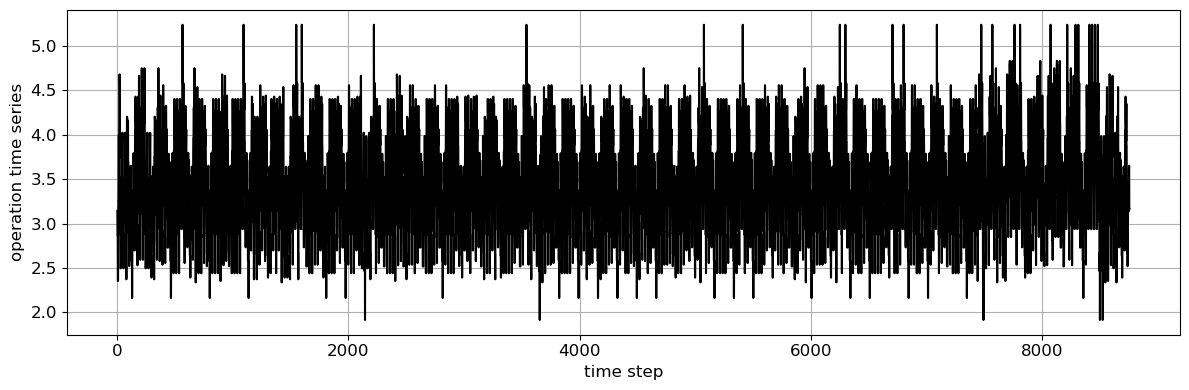

In [19]:
fig, ax = fn.plotOperation(esM, "Electricity demand", "GermanyRegion", ip=2020)

 Electricity demand operation for Investment Period 2030

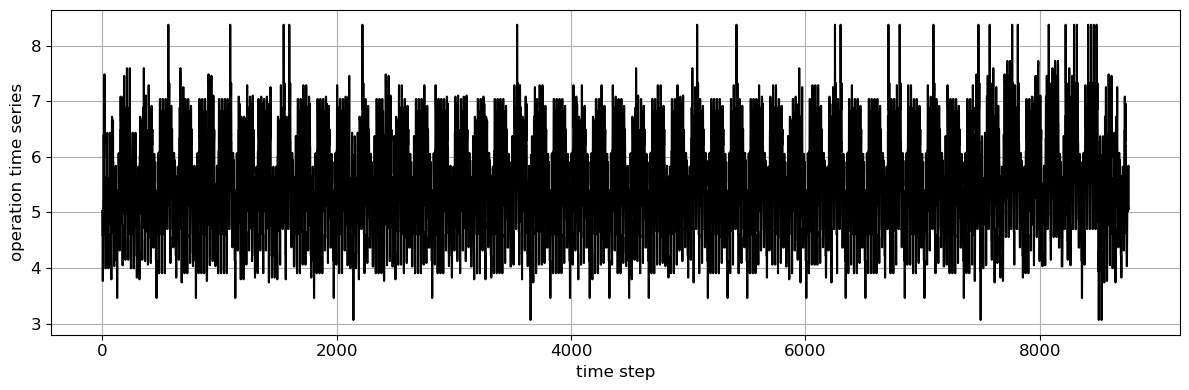

In [20]:
fig, ax = fn.plotOperation(esM, "Electricity demand", "GermanyRegion", ip=2030)

 Operation color map for Electricity demand in Investment Period 2020

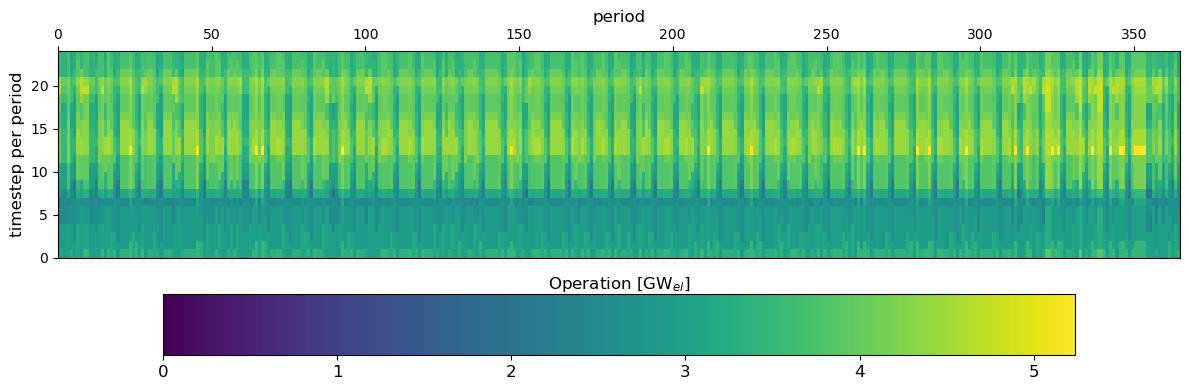

In [21]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "GermanyRegion",ip=2020)

 Operation color map for Electricity demand in Investment Period 2030

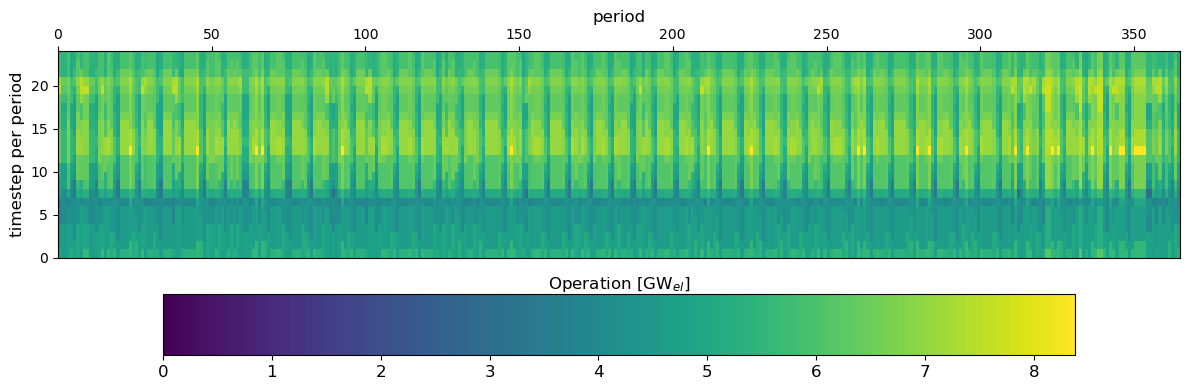

In [22]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "GermanyRegion",ip=2030)

 ### Conversion

 Show optimization summary

In [23]:
for year in [2020,2025,2030]:
    print(f"\n Results of ConversionMpdel for year {year}")
    esM.getOptimizationSummary("ConversionModel", outputLevel=2, ip=year)


 Results of ConversionMpdel for year 2020

 Results of ConversionMpdel for year 2025

 Results of ConversionMpdel for year 2030


 Operation color map for New CCGT plants (hydrogen) in Investment Period 2020

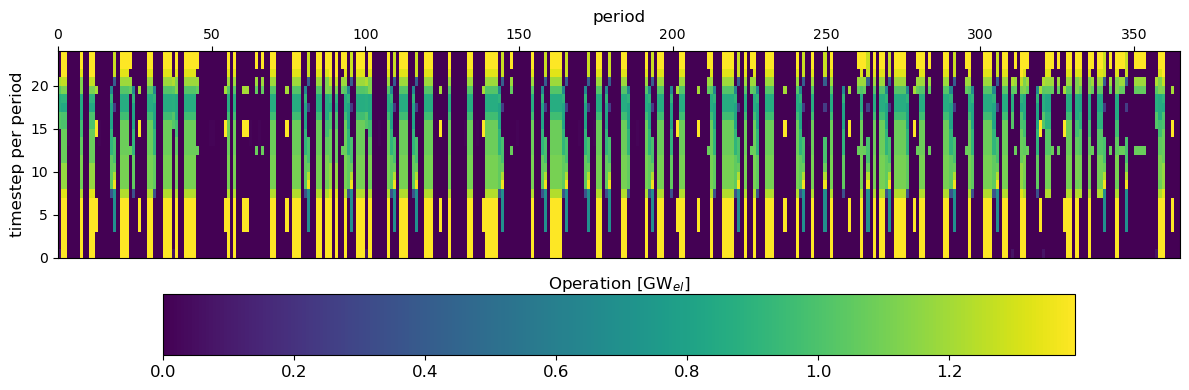

In [24]:
fig, ax = fn.plotOperationColorMap(esM, "New CCGT plants (hydrogen)", "GermanyRegion", ip=2020)

 Operation color map for New CCGT plants (hydrogen) in Investment Period 2030

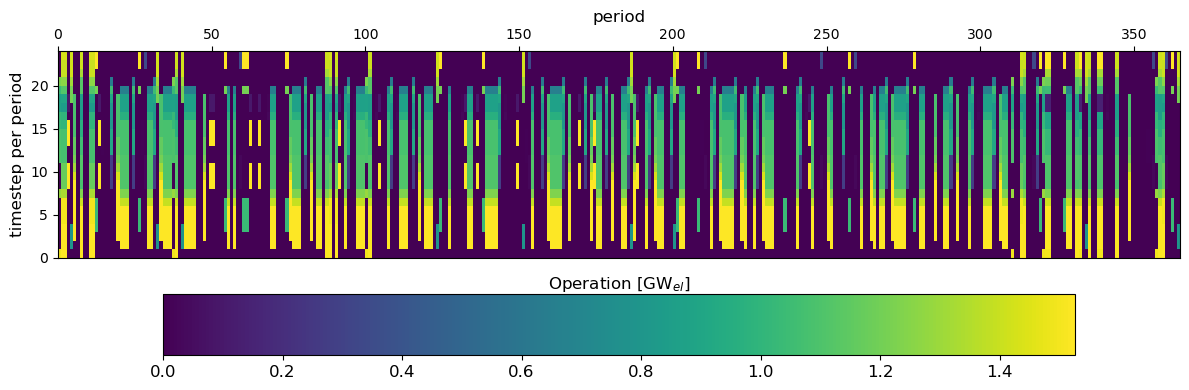

In [25]:
fig, ax = fn.plotOperationColorMap(esM, "New CCGT plants (hydrogen)", "GermanyRegion", ip=2030)

 ### Storage

 Show optimization summary

In [26]:
for year in [2020,2025,2030]:
    print(f"\n Results of StorageModel for year {year}")
    print(esM.getOptimizationSummary("StorageModel", outputLevel=2, ip=year))


 Results of StorageModel for year 2020
                                                                  GermanyRegion
Component               Property           Unit                                
Li-ion batteries        NPVcontribution    [1e9 Euro]                  3.656265
                        TAC                [1e9 Euro/a]                0.847903
                        capacity           [GW$_{el}$*h]              48.787021
                        capexCap           [1e9 Euro/a]                0.750329
                        commissioning      [GW$_{el}$*h]              48.787021
                        invest             [1e9 Euro]                   7.36684
                        operationCharge    [GW$_{el}$*h/a]          5920.124728
                                           [GW$_{el}$*h]            5920.124728
                        operationDischarge [GW$_{el}$*h/a]          5333.377587
                                           [GW$_{el}$*h]            5333.377587


 Operation color map for Li-ion batteries in Investment Period 2020

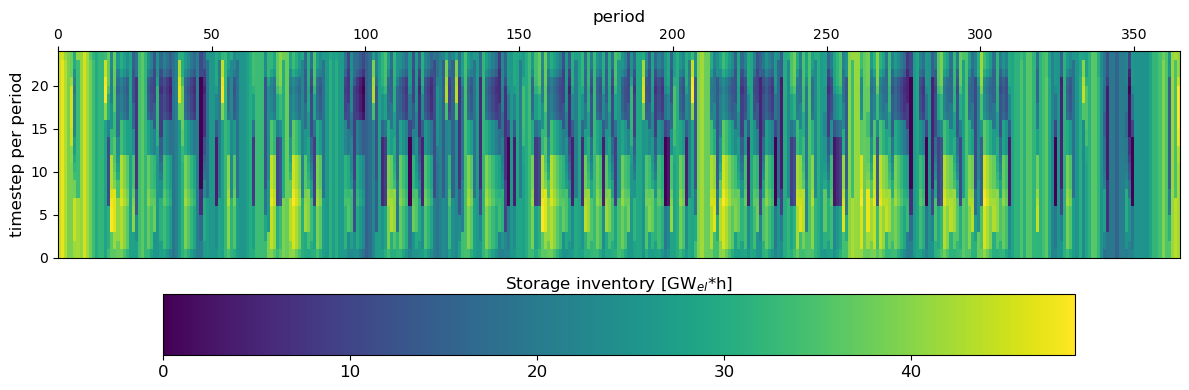

In [27]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2020
)

 Operation color map for Li-ion batteries in Investment Period 2025

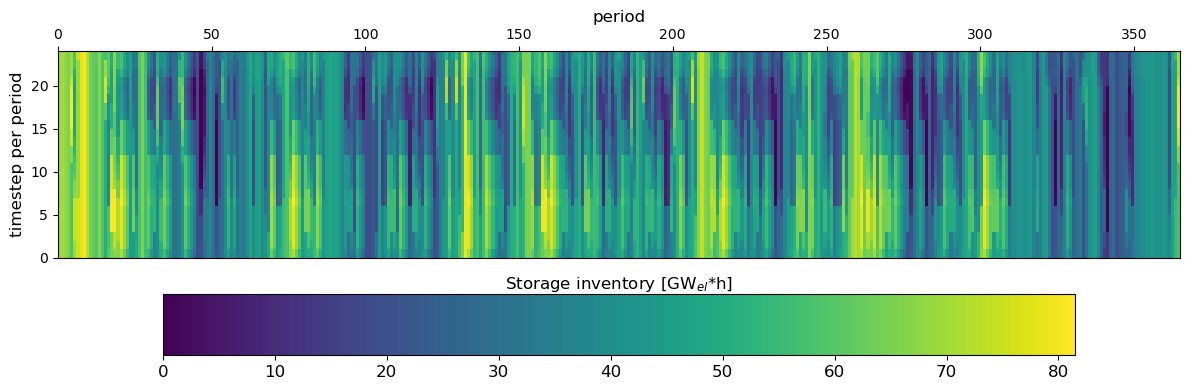

In [28]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2025
)

 Operation color map for Li-ion batteries in Investment Period 2030

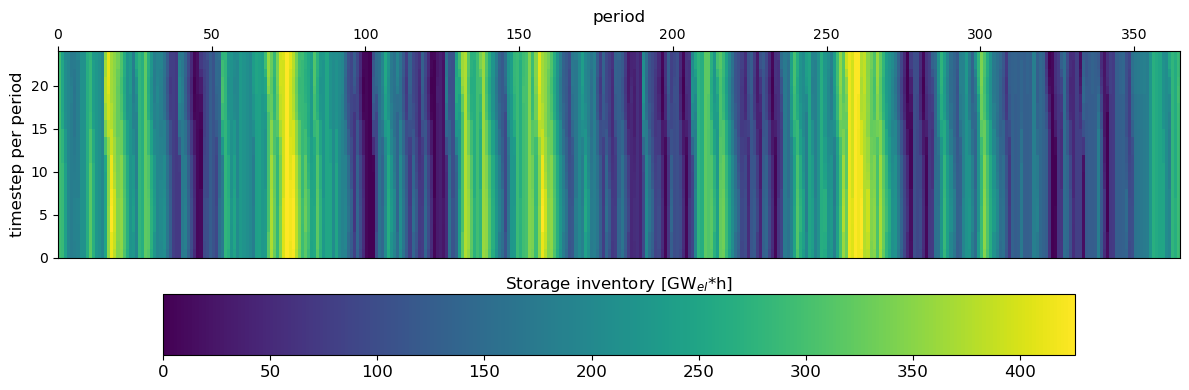

In [29]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2030
)

 Operation color map for Salt caverns (hydrogen) in Investment Period 2020

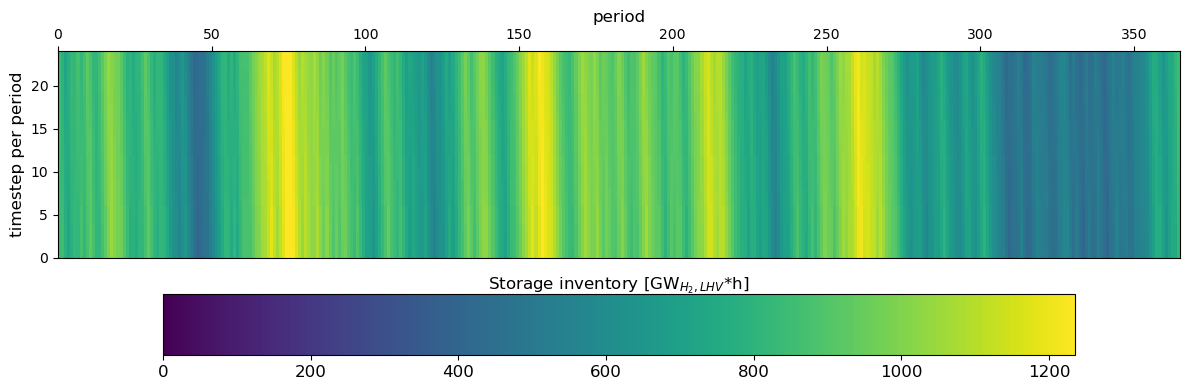

In [30]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (hydrogen)",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2020
)

 Operation color map for Salt caverns (hydrogen) in Investment Period 2025

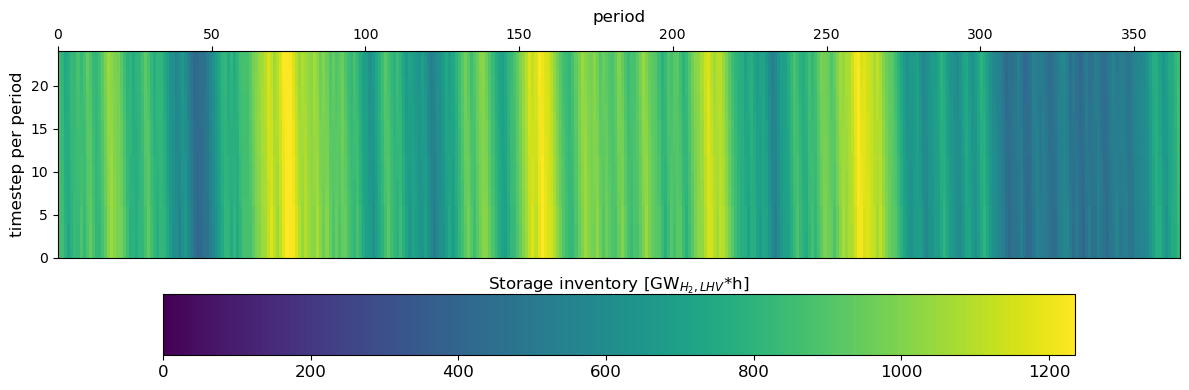

In [31]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (hydrogen)",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2025
)

 Operation color map for Salt caverns (hydrogen) in Investment Period 2030

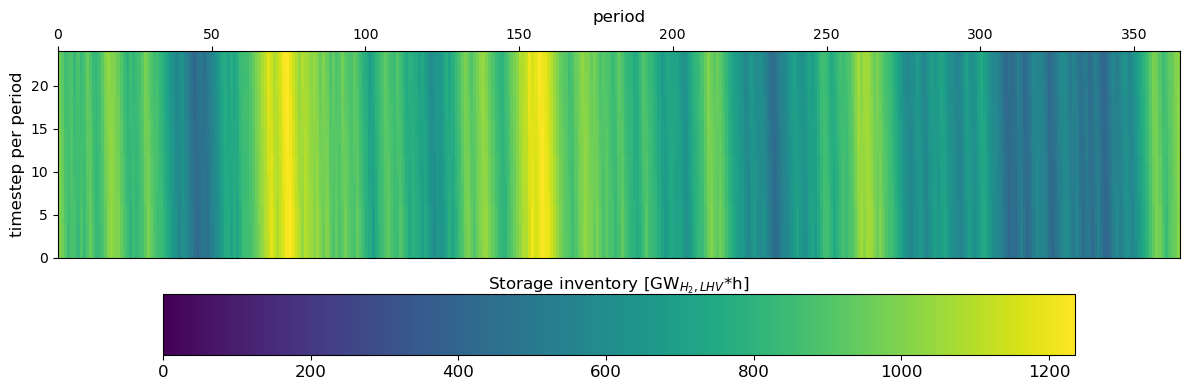

In [32]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (hydrogen)",
    "GermanyRegion",
    variableName="stateOfChargeOperationVariablesOptimum",
    ip=2030
)